# UnionML Demo

In [1]:
from pictionary_app import model

num_classes = 200

execution = model.remote_train(
    hyperparameters={"num_classes": num_classes},
    trainer_kwargs={"num_epochs": 1},
    data_dir="./data",
    max_examples_per_class=10000,
    class_limit=num_classes,
)

Executing quickdraw_classifier.train, execution name: f3c30064a4ffb4cc4914.
Go to https://playground.hosted.unionai.cloud/console/projects/unionml/domains/development/executions/f3c30064a4ffb4cc4914 to see the execution in the console.


# 🚨🚨🚨 **NOTE FOR UNION.AI TEAM** 🚨🚨🚨 The following other settings will hopefully be cached and good
to go for use in the demo. You can try it out, and replace the code snippet above with one of the ones below.

### More labels:

- execution: https://playground.hosted.unionai.cloud/console/projects/unionml/domains/development/executions/f27171bd39bec4f04929?duration=all

```python
num_classes = 200

execution = model.remote_train(
    hyperparameters={"num_classes": num_classes},
    trainer_kwargs={"num_epochs": 1},
    data_dir="./data",
    max_examples_per_class=10000,
    class_limit=num_classes,
)
```

### More labels, trained for longer

- execution: https://playground.hosted.unionai.cloud/console/projects/unionml/domains/development/executions/f444bd69e68c747a59cf?duration=all

```python
num_classes = 200

execution = model.remote_train(
    hyperparameters={"num_classes": num_classes},
    trainer_kwargs={"num_epochs": 20},
    data_dir="./data",
    max_examples_per_class=10000,
    class_limit=num_classes,
)
```

### All labels, trained for longer

- cpu execution: https://playground.hosted.unionai.cloud/console/projects/unionml/domains/development/executions/f23f637d2f3b74460a6f?duration=all
- gpu execution: https://playground.hosted.unionai.cloud/console/projects/unionml/domains/development/executions/f03bd4bc57adf4db1b46?duration=all

```python
num_classes = 345

execution = model.remote_train(
    hyperparameters={"num_classes": num_classes},
    trainer_kwargs={"num_epochs": 20},
    data_dir="./data",
    max_examples_per_class=10000,
    class_limit=num_classes,
)
```

### All labels, trained for longer much longer on gpu

- execution: https://playground.hosted.unionai.cloud/console/projects/unionml/domains/development/executions/fe652be0db07b473383e?duration=all

```python
num_classes = 345

execution = model.remote_train(
    hyperparameters={"num_classes": num_classes},
    trainer_kwargs={"num_epochs": 45},
    data_dir="./data",
    max_examples_per_class=10000,
    class_limit=num_classes,
)
```

In [2]:
# wait for the execution to complete, then load model from remote
model.remote_load(execution)

Waiting for execution f3c30064a4ffb4cc4914 to complete...
Done.


In [3]:
import gradio as gr

gr.Interface(
    fn=model.predict,
    inputs="sketchpad",
    outputs="label",
    live=True,
    allow_flagging="never",
).launch()

Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


(<fastapi.applications.FastAPI at 0x7f37e23279a0>,
 'http://127.0.0.1:7860/',
 None)

# Flytekit Demo

In [4]:
from pictionary_app.dataset import QuickDrawDataset

dataset = QuickDrawDataset("/tmp/quickdraw_data", max_items_per_class=1000, class_limit=num_classes)
dataset

  0%|          | 0/200 [00:00<?, ?it/s]

Loading 1000 examples for each class from the Quickdraw Dataset...


  0%|          | 0/200 [00:00<?, ?it/s]

In [5]:
model.artifact.model_object

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2304, out_features=512, bias=True)
  (11): ReLU()
  (12): Linear(in_features=512, out_features=200, bias=True)
)

Create a `FlyteRemote` object and fetch the batch prediction workflow

In [6]:
from flytekit.remote import FlyteRemote
from flytekit.configuration import Config


remote = FlyteRemote(config=Config.auto(config_file="./config/config-remote.yaml"), data_upload_location="s3://open-compute-playground/data")
wf = remote.fetch_workflow(project="unionml", domain="development", name="flytekit_demo.batch_predictions.wf", version="a054667ca0ff3d5c497e6dda29eaeef4629b9c61")

Get features and labels

In [7]:
import random
from pictionary_app.dataset import get_quickdraw_class_names

feature_list = []
label_list = []
class_names = get_quickdraw_class_names()
# Grab a few random entries from the original dataset
for i in range(28):
    X, y = dataset[random.randint(0, 1000 * num_classes)]
    feature_list.append(X.squeeze())
    label_list.append(class_names[y])

In [8]:
# NOTE: make sure you have aws credentials for the s3://open-compute-playground bucket
execution = remote.execute(
    wf,
    inputs={"model_object": model.artifact.model_object, "feature_list": feature_list},
    project="unionml",
    domain="development",
    wait=True,
)

In [9]:
import typing

# Inspect the result of call to batch_predictions workflow
predictions = execution.outputs.get('o0', typing.List[dict])

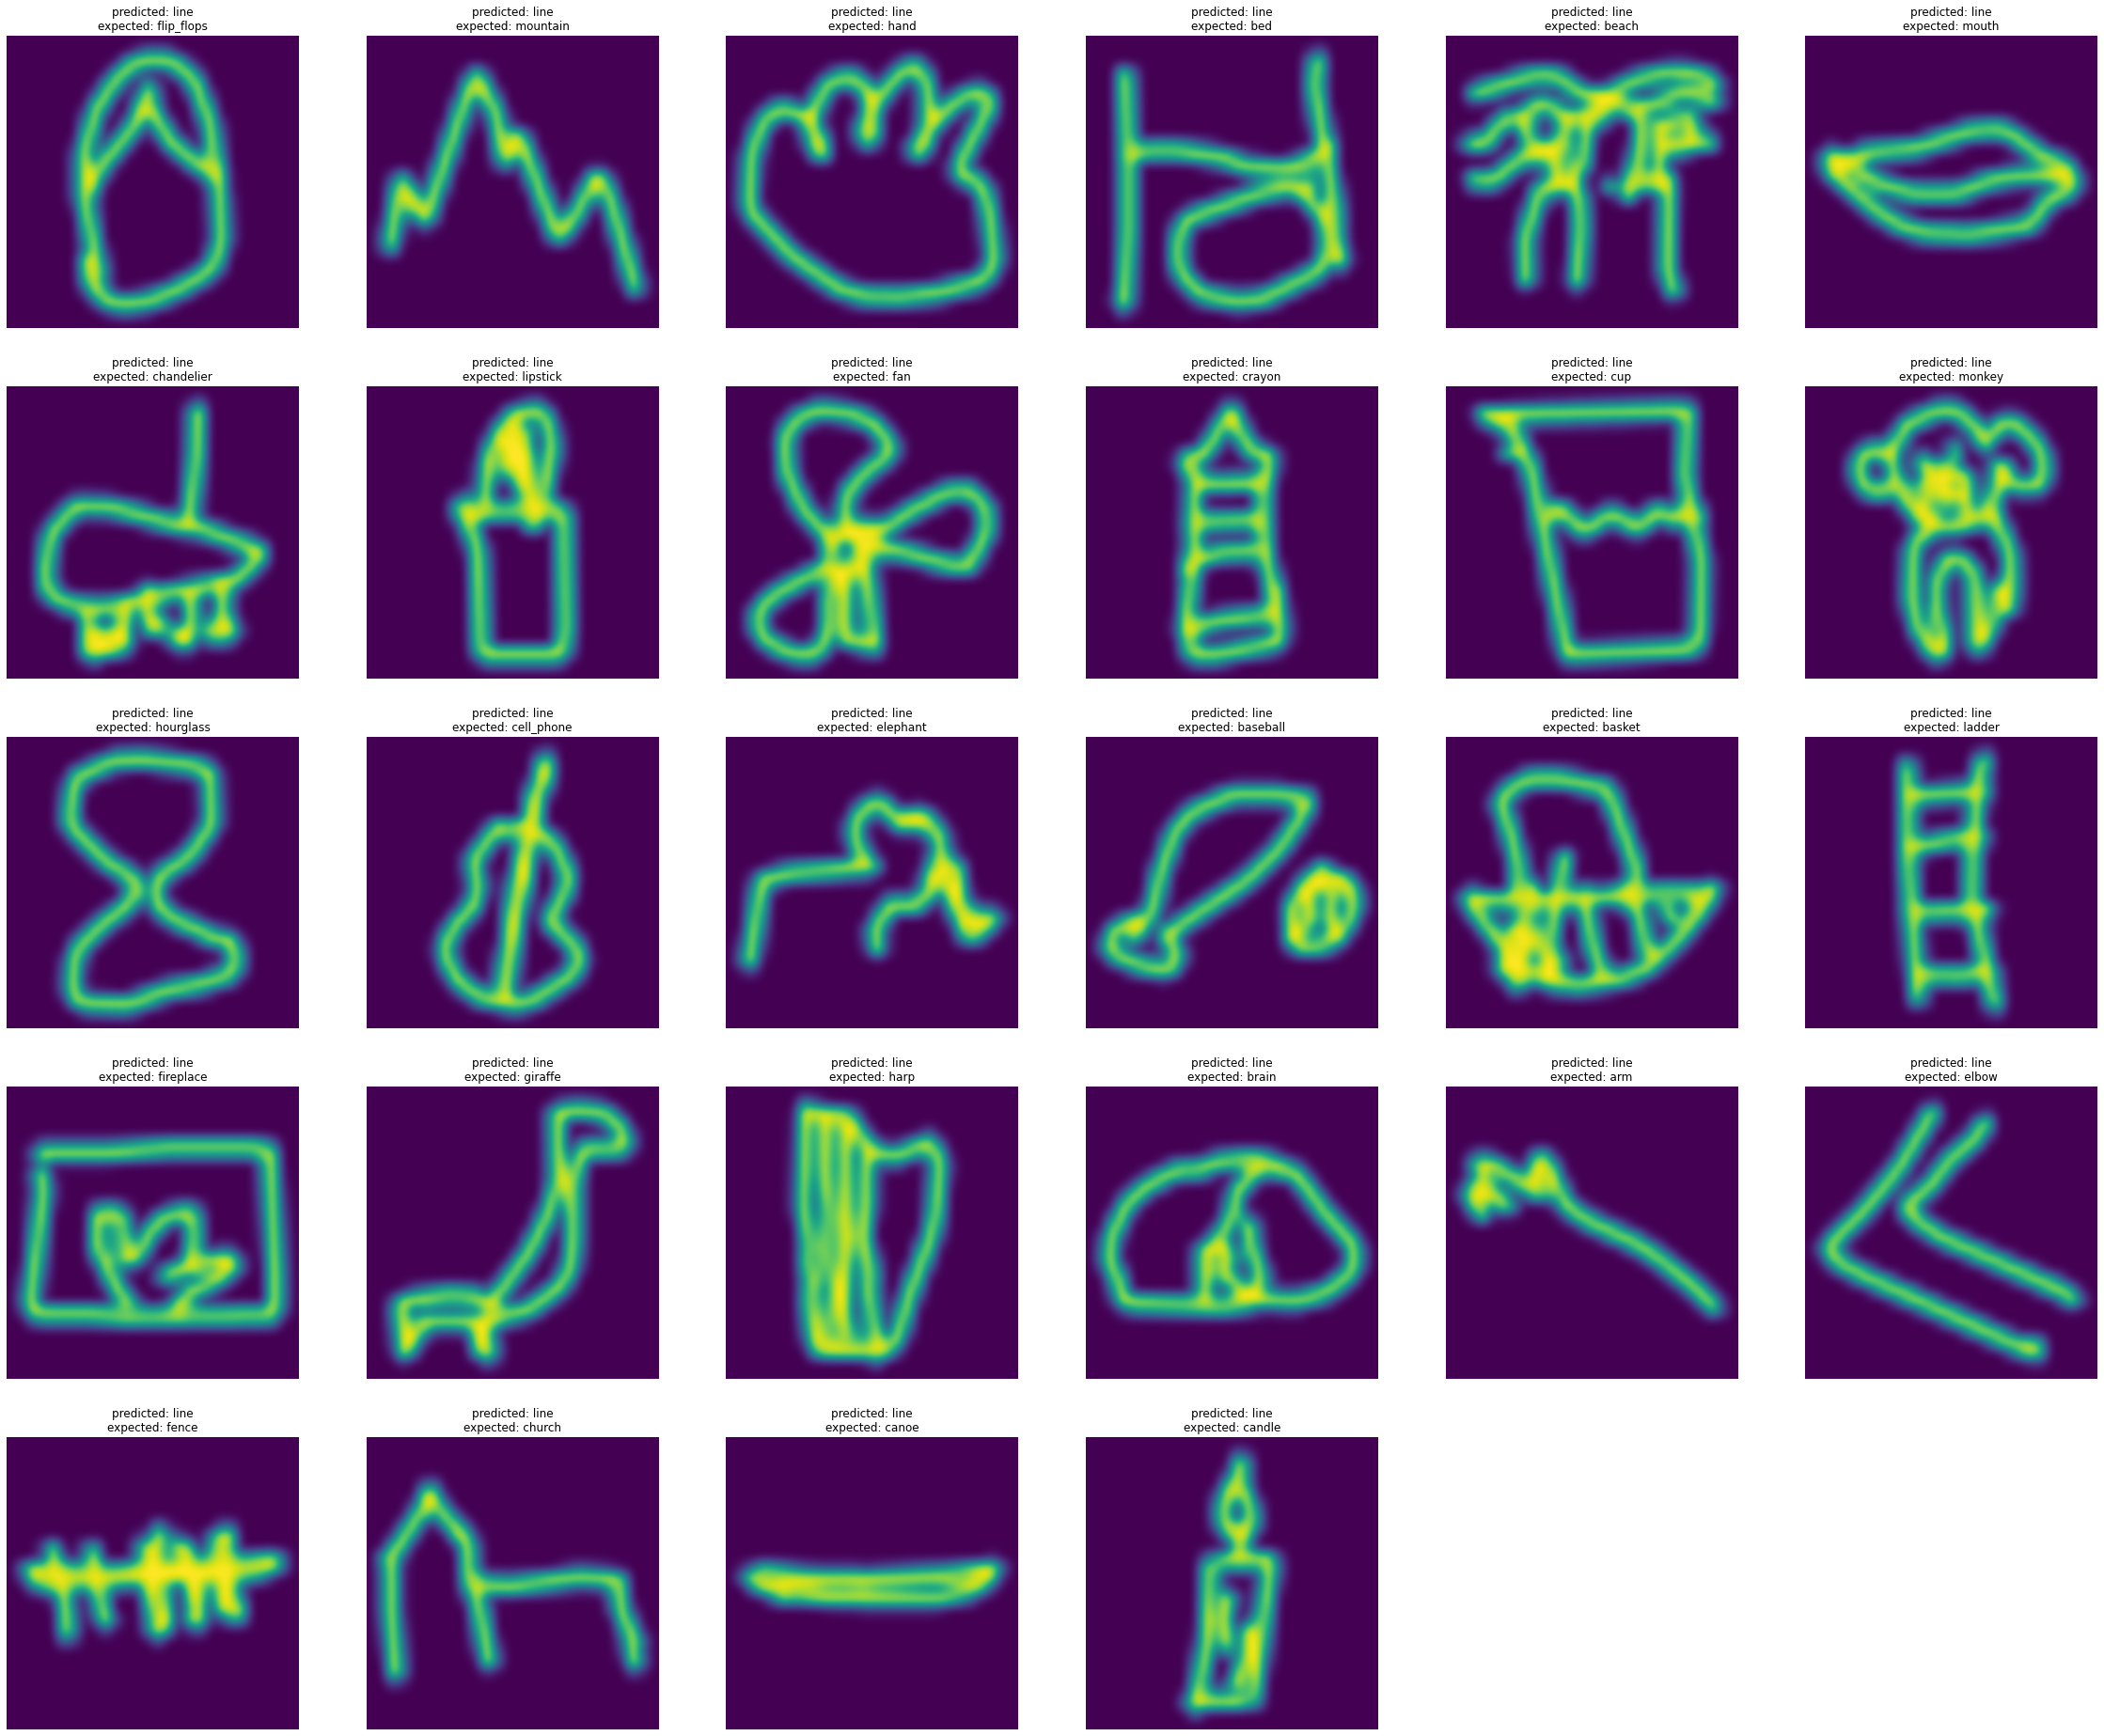

In [11]:
import math
from matplotlib import pyplot as plt

# Arrange results in a square where each image contains the prediction alongside with the original label
fig = plt.figure(figsize=(40, 40))

sqr = math.sqrt(len(predictions))
rows = math.ceil(sqr)
columns = math.floor(sqr) + 1

for i in range(len(predictions)):
    best_prediction = max(predictions[i], key=predictions[i].get)
    expected_label = label_list[i]

    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(feature_list[i], interpolation='bicubic')
    plt.axis('off')
    plt.title(f"predicted: {best_prediction}\nexpected: {expected_label}")